# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## EDA

### Importing libraries

In [133]:
import pandas as pd
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [134]:
data_dir = Path('../assets/data/elections2022')
november_df = pd.read_csv(data_dir / '2021_11.csv', sep=';')
december_df = pd.read_csv(data_dir / '2021_12.csv', sep=';')
december_df.describe()

,pesquisa_id,ano,unidades_federativas_id,cargos_id,tipo_id,turno,instituto_id,cenario_id,candidatos_id,condicao,percentual,margem_mais,margem_menos,num_registro,orgao_registro,qtd_entrevistas,partidos_id,cidade
count,299.000000,299.0,299.0,299.0,299.0,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,0.0,0.0,299.000000,299.000000,0.0
mean,9761.675585,2022.0,6.0,3.0,2.0,1.434783,188.58194,24655.598662,1901.418060,0.341137,18.041137,2.408027,2.408027,NaN,NaN,2111.200669,16.956522,NaN
std,4.821488,0.0,0.0,0.0,0.0,0.496560,130.21952,30.562393,1890.381209,0.474886,17.174248,0.468543,0.468543,NaN,NaN,891.841771,16.514427,NaN
min,9755.000000,2022.0,6.0,3.0,2.0,1.000000,39.00000,24603.000000,209.000000,0.000000,0.000000,2.000000,2.000000,NaN,NaN,1000.000000,1.000000,NaN
25%,9758.000000,2022.0,6.0,3.0,2.0,1.000000,64.00000,24638.500000,706.000000,0.000000,3.000000,2.000000,2.000000,NaN,NaN,1200.000000,1.000000,NaN
50%,9761.000000,2022.0,6.0,3.0,2.0,1.000000,94.00000,24656.000000,973.000000,0.000000,10.000000,2.200000,2.200000,NaN,NaN,2002.000000,15.000000,NaN
75%,9766.000000,2022.0,6.0,3.0,2.0,2.000000,332.00000,24681.000000,1706.500000,1.000000,31.000000,3.000000,3.000000,NaN,NaN,3000.000000,33.000000,NaN
max,9769.000000,2022.0,6.0,3.0,2.0,2.000000,356.00000,24706.000000,6057.000000,1.000000,60.000000,3.200000,3.200000,NaN,NaN,3666.000000,62.000000,NaN


Lets filter our dataframe to have just the columns we will use.

In [135]:
columns_to_use = ["pesquisa_id", "cenario_id","turno", "partido", "candidato", "cenario_descricao", "instituto", "percentual", "data_referencia", "qtd_entrevistas"]
december_simple_df = december_df[columns_to_use].copy()
november_simple_df = november_df[columns_to_use].copy()

##### Getting invalid votes intentions (first turn).

Grouped by `pesquisa_id`, `cenario_id` and `turno == 1`

In [136]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido.isna())].head(20)

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas
0,9764,24661,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Datafolha,8.0,13-16.dez.2021,3666
33,9764,24662,1,NaN,branco / nulo / nenhum,cenário 2 - estimulado - 1º turno,Datafolha,8.0,13-16.dez.2021,3666
34,9764,24662,1,NaN,não sabe,cenário 2 - estimulado - 1º turno,Datafolha,2.0,13-16.dez.2021,3666
41,9764,24661,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,Datafolha,2.0,13-16.dez.2021,3666
48,9760,24647,1,NaN,nenhum / não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Futura,3.7,7-13.dez.2021,2000
50,9760,24647,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Futura,4.8,7-13.dez.2021,2000
62,9760,24648,1,NaN,não sabe / não respondeu,cenário 2 - estimulado - 1º turno,Futura,3.2,7-13.dez.2021,2000
63,9760,24648,1,NaN,branco / nulo,cenário 2 - estimulado - 1º turno,Futura,7.7,7-13.dez.2021,2000
65,9760,24649,1,NaN,nenhum / não sabe / não respondeu,cenário 3 - estimulado - 1º turno,Futura,2.4,7-13.dez.2021,2000
66,9760,24649,1,NaN,branco / nulo,cenário 3 - estimulado - 1º turno,Futura,4.6,7-13.dez.2021,2000


#### Lula vote intentions (first turn)


In [137]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido=="PT")].head(20)

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas
37,9764,24662,1,PT,Lula,cenário 2 - estimulado - 1º turno,Datafolha,47.0,13-16.dez.2021,3666
46,9764,24661,1,PT,Lula,cenário 1 - estimulado - 1º turno,Datafolha,48.0,13-16.dez.2021,3666
49,9760,24647,1,PT,Lula,cenário 1 - estimulado - 1º turno,Futura,37.9,7-13.dez.2021,2000
59,9760,24648,1,PT,Lula,cenário 2 - estimulado - 1º turno,Futura,39.4,7-13.dez.2021,2000
67,9760,24649,1,PT,Lula,cenário 3 - estimulado - 1º turno,Futura,42.4,7-13.dez.2021,2000
75,9760,24650,1,PT,Lula,cenário 4 - estimulado - 1º turno,Futura,43.8,7-13.dez.2021,2000
106,9758,24637,1,PT,Lula,cenário 2 - estimulado - 1º turno,Ideia Big Data,38.0,6-9.dez.2021,1200
110,9758,24638,1,PT,Lula,cenário 3 - estimulado - 1º turno,Ideia Big Data,38.0,6-9.dez.2021,1200
115,9758,24639,1,PT,Lula,cenário 4 - estimulado - 1º turno,Ideia Big Data,42.0,6-9.dez.2021,1200
128,9758,24636,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ideia Big Data,37.0,6-9.dez.2021,1200


### Add qtdy
$$qtd\_mencoes = (percentual * qtd\_entrevistas)\div 100.00$$

In [138]:
december_simple_df['qtd_mencoes'] = december_simple_df.percentual * december_simple_df.qtd_entrevistas / 100.0
november_simple_df['qtd_mencoes'] = november_simple_df.percentual * november_simple_df.qtd_entrevistas / 100.0


In [139]:
november_simple_df[(november_simple_df.turno==1) & (november_simple_df.partido.isna()) & (november_simple_df.cenario_descricao.str.startswith('cenário 1'))]

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,30.out-4.nov.2021,2000,240.000
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,30.out-4.nov.2021,2000,200.000
28,9749,24559,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Quaest,10.0,3-6.nov.2021,2063,206.300
29,9749,24559,1,NaN,indeciso,cenário 1 - estimulado - 1º turno,Quaest,4.0,3-6.nov.2021,2063,82.520
40,9751,24572,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Paraná Pesquisas,3.5,16-19.nov.2021,2020,70.700
41,9751,24572,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Paraná Pesquisas,9.9,16-19.nov.2021,2020,199.980
78,9753,24583,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Futura,4.0,16-20.nov.2021,2000,80.000
79,9753,24583,1,NaN,indeciso / não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Futura,3.6,16-20.nov.2021,2000,72.000
117,9752,24580,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,PoderData,3.0,22-24.nov.2021,2500,75.000
118,9752,24580,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,PoderData,6.0,22-24.nov.2021,2500,150.000


Prior Lula

In [140]:
november_simple_df[(november_simple_df.turno==1) & (november_simple_df.partido=="PT") & (november_simple_df.cenario_descricao.str.startswith('cenário 1'))]#.sum(axis=0)

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,30.out-4.nov.2021,2000,880.000
21,9749,24559,1,PT,Lula,cenário 1 - estimulado - 1º turno,Quaest,48.0,3-6.nov.2021,2063,990.240
42,9751,24572,1,PT,Lula,cenário 1 - estimulado - 1º turno,Paraná Pesquisas,34.9,16-19.nov.2021,2020,704.980
80,9753,24583,1,PT,Lula,cenário 1 - estimulado - 1º turno,Futura,38.6,16-20.nov.2021,2000,772.000
116,9752,24580,1,PT,Lula,cenário 1 - estimulado - 1º turno,PoderData,34.0,22-24.nov.2021,2500,850.000
134,9754,24593,1,PT,Lula,cenário 1 - estimulado - 1º turno,Atlas,42.8,27-29.nov.2021,4401,1883.628


Prior Brancos e Nulos

In [141]:
bn_df = november_simple_df[(november_simple_df.turno==1) & (november_simple_df.partido.isna()) & (november_simple_df.cenario_descricao.str.startswith('cenário 1'))]
bn_df.groupby(['cenario_id']).agg(bn=('qtd_mencoes', 'sum'), total=('qtd_entrevistas', 'max')).sum(axis=0)

bn        1517.332
total    14984.000
dtype: float64

Likelihood Lula

In [142]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido=="PT") & (december_simple_df.cenario_descricao.str.startswith('cenário 1'))]#.sum()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
46,9764,24661,1,PT,Lula,cenário 1 - estimulado - 1º turno,Datafolha,48.0,13-16.dez.2021,3666,1759.680
49,9760,24647,1,PT,Lula,cenário 1 - estimulado - 1º turno,Futura,37.9,7-13.dez.2021,2000,758.000
128,9758,24636,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ideia Big Data,37.0,6-9.dez.2021,1200,444.000
153,9761,24656,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ipec,48.0,9-13.dez.2021,2002,960.960
164,9769,24699,1,PT,Lula,cenário 1 - estimulado - 1º turno,Ipespe,44.0,14-16.dez.2021,1000,440.000
208,9762,24658,1,PT,Lula,cenário 1 - estimulado - 1º turno,MDA,42.8,9-11.dez.2021,2002,856.856
218,9768,24692,1,PT,Lula,cenário 1 - estimulado - 1º turno,PoderData,40.0,19-21.dez.2021,3000,1200.000
270,9755,24603,1,PT,Lula,cenário 1 - estimulado - 1º turno,Quaest,47.0,2-5.dez.2021,2037,957.390


Likelihodd brancos e nulos

In [143]:
bn_df = december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido.isna()) & (december_simple_df.cenario_descricao.str.startswith('cenário 1'))]
bn_df.groupby(['cenario_id']).agg(bn=('qtd_mencoes', 'sum'), total=('qtd_entrevistas', 'max')).sum(axis=0)

bn        1953.256
total    16907.000
dtype: float64

## Playing with the Dirichlet Multinomial

In [144]:
with pm.Model() as dirichlet_model:
    # november_prior = pm.Dirichlet(
    #     "november_prior",
    #     # Lula, BrancosNulosNaoSabem, Demais candidatos
    #     # a=pd.array([6080, 1517, 7387]).astype("float32")
    #     # a=pd.array([1.0, 1.0, 1.0]).astype("float32"),
    # )
    
    #unif = pm.Uniform("unif", lower=2, upper=5)
    
    beta = pm.Beta("beta", alpha=4, beta=1)
    
    november_prior = pm.Dirichlet(
        "november_prior",
        # Lula, BrancosNulosNaoSabem, Demais candidatos
        a=pd.array([6080, 1517, 7387]).astype("float32") * beta,
        # a=pd.array([1.0, 1.0, 1.0]).astype("float32"),
    )
    
    december_like = pm.Multinomial(
        "december_like", n=16907//1 -  0, p=november_prior, observed=pd.array([7376//1, 1953//1, 7578//1])
    )
    

/tmp/ipykernel_2819300/3691293885.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  dirichlet_trace = pm.sample(5000, chains=4) # 20K samples
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [november_prior, beta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 27 seconds.


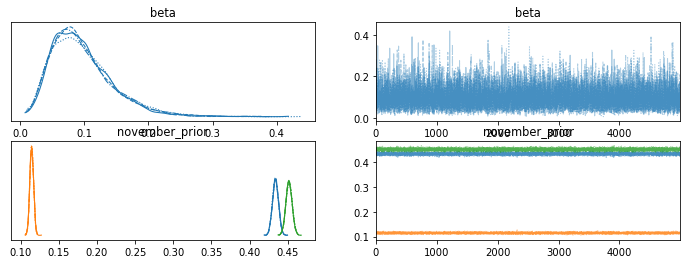

In [145]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=4) # 20K samples
   ppc = pm.sample_posterior_predictive(
        dirichlet_trace, random_seed=1777,
   )
   az.plot_trace(dirichlet_trace)

In [146]:
az.summary(dirichlet_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.096,0.048,0.022,0.187,0.0,0.0,14126.0,11402.0,1.0
november_prior[0],0.434,0.004,0.426,0.441,0.0,0.0,13290.0,14935.0,1.0
november_prior[1],0.114,0.002,0.110,0.119,0.0,0.0,9682.0,11860.0,1.0
november_prior[2],0.452,0.004,0.444,0.459,0.0,0.0,19436.0,15395.0,1.0


In [147]:
print(ppc)
ppc['december_like'].mean(axis=0)

{'december_like': array([[7374., 1999., 7534.],
       [7406., 1981., 7520.],
       [7417., 1878., 7612.],
       ...,
       [7288., 1927., 7692.],
       [7331., 1834., 7742.],
       [7387., 1968., 7552.]])}


array([7336.13015, 1935.15975, 7635.7101 ])

In [148]:
lula = ppc['december_like'][:, 0]
demais = ppc['december_like'][:, 2]
lula.shape,demais.shape

((20000,), (20000,))

In [149]:
(lula > demais).mean()

0.0429

# Janeiro/Dezembro

3445


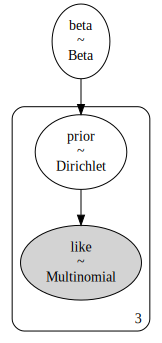

In [150]:
T1 = 2_000 # 
T2 = 1500

# Mês atual: Lula, BrancosNulosNaoSabem, Demais candidatos
current_observed = pd.array([int(T1 * 0.45 + T2 * 0.41), int(T1 * 0.12 + T2*0.11), int(T1 * 0.41 + T2 * 0.47)])

print(current_observed.sum())
                    
with pm.Model() as dirichlet_model:
    
    # unif = pm.Uniform("unif", lower=2, upper=5)
    
    beta = pm.Beta("beta", alpha=5, beta=1)
    
    december_prior = pm.Dirichlet(
        "prior",
        # Mes anterior: Lula, BrancosNulosNaoSabem, Demais candidatos
        a=pd.array([7376, 1953, 7578]).astype("float32") * beta,
    )
    
    january_like = pm.Multinomial(
        "like", n=current_observed.sum(), p=december_prior, observed=current_observed
    )
pm.model_to_graphviz(dirichlet_model)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prior, beta]
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 17 seconds.
/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (20000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


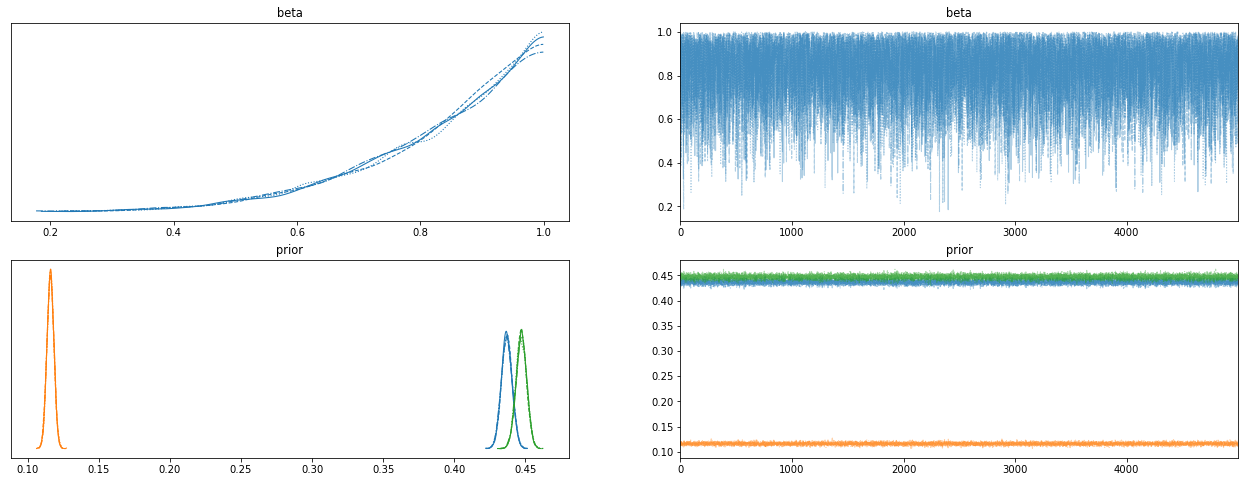

In [151]:
with dirichlet_model:
   dirichlet_trace = pm.sample(5000, chains=4, return_inferencedata=True, cores=4, progressbar=False) # 20K samples
   ppc = pm.fast_sample_posterior_predictive(
        dirichlet_trace, random_seed=1777
   )
   az.plot_trace(dirichlet_trace, figsize=(22,8))
   dirichlet_trace.extend(az.from_dict(posterior_predictive=ppc))

In [152]:
az.summary(dirichlet_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.836,0.137,0.579,1.000,0.001,0.001,10227.0,7652.0,1.0
prior[0],0.437,0.004,0.430,0.444,0.000,0.000,12783.0,13777.0,1.0
prior[1],0.116,0.002,0.111,0.120,0.000,0.000,8895.0,10234.0,1.0
prior[2],0.447,0.004,0.440,0.454,0.000,0.000,21259.0,13861.0,1.0


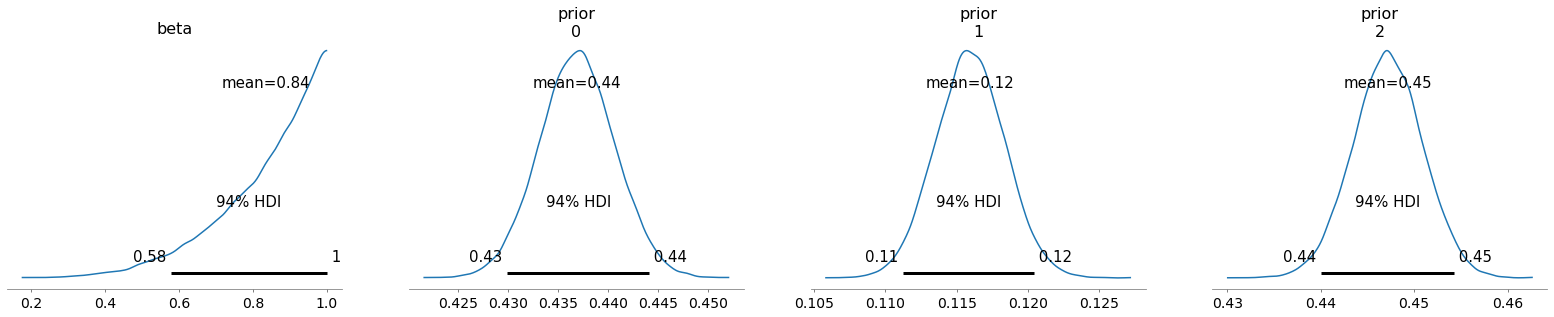

In [158]:
az.plot_posterior(dirichlet_trace);

In [154]:
lula = ppc['like'][:, 0]
demais = ppc['like'][:, 2]
print(lula.shape,demais.shape)
prob_lula = (lula > demais).mean() * 100.0
print(f"Probabilidade de Lula vencer no primeiro turno é de: {prob_lula:.2f}%", )

(20000,) (20000,)
Probabilidade de Lula vencer no primeiro turno é de: 28.17%


## Playground

In [155]:
december_simple_df[(december_simple_df.turno==1) & (december_simple_df.partido.isna()) & (december_simple_df.cenario_descricao.str.startswith('cenário 1'))]

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_referencia,qtd_entrevistas,qtd_mencoes
0,9764,24661,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Datafolha,8.0,13-16.dez.2021,3666,293.280
41,9764,24661,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,Datafolha,2.0,13-16.dez.2021,3666,73.320
48,9760,24647,1,NaN,nenhum / não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Futura,3.7,7-13.dez.2021,2000,74.000
50,9760,24647,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Futura,4.8,7-13.dez.2021,2000,96.000
137,9758,24636,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Ideia Big Data,10.0,6-9.dez.2021,1200,120.000
138,9758,24636,1,NaN,não sabe,cenário 1 - estimulado - 1º turno,Ideia Big Data,3.0,6-9.dez.2021,1200,36.000
147,9761,24656,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Ipec,5.0,9-13.dez.2021,2002,100.100
148,9761,24656,1,NaN,branco / nulo,cenário 1 - estimulado - 1º turno,Ipec,9.0,9-13.dez.2021,2002,180.180
165,9769,24699,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Ipespe,3.0,14-16.dez.2021,1000,30.000
166,9769,24699,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Ipespe,9.0,14-16.dez.2021,1000,90.000


In [156]:
# probs = []
# for x in range(30):
#     with dirichlet_model:
#         dirichlet_trace = pm.sample(5000) # 100K samples
#         ppc = pm.sample_posterior_predictive(
#                 dirichlet_trace, random_seed=777,
#         )
#     lula = ppc['december_like'][:, 0]
#     demais = ppc['december_like'][:, 2]
#     probs.append((lula > demais).mean())

In [157]:
pd.np.mean(probs), pd.np.std(probs)

/tmp/ipykernel_2819300/697546233.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.mean(probs), pd.np.std(probs)


NameError: name 'probs' is not defined